In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [ ]:
daisy_path = '/content/drive/MyDrive/ML/flowers/daisy'
dandelion_path = '/content/drive/MyDrive/ML/flowers/dandelion'
rose_path = '/content/drive/MyDrive/ML/flowers/rose'
sunflower_path = '/content/drive/MyDrive/ML/flowers/sunflower'
tulip_path = '/content/drive/MyDrive/ML/flowers/tulip'

count = 0
dirs = os.listdir('/content/drive/MyDrive/ML/flowers/')
for dir in dirs:
    files = list(os.listdir('/content/drive/MyDrive/ML/flowers/' + dir))
    print(dir + ' folder has ' + str(len(files)) + ' images')
    count = count + len(files)
print('The dataset contains ' + str(count) + ' images in total')

base_dir = '/content/drive/MyDrive/ML/flowers/'
img_size = 180
batch = 32


dandelion folder has 1052 images
sunflower folder has 733 images
rose folder has 784 images
daisy folder has 764 images
tulip folder has 984 images
The dataset contains 4317 images in total


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       batch_size = batch,
                                                       image_size = (img_size, img_size)
                                                       )

val_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       batch_size = batch,
                                                       image_size = (img_size, img_size)
                                                       )

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
flower_name = train_ds.class_names
flower_name

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

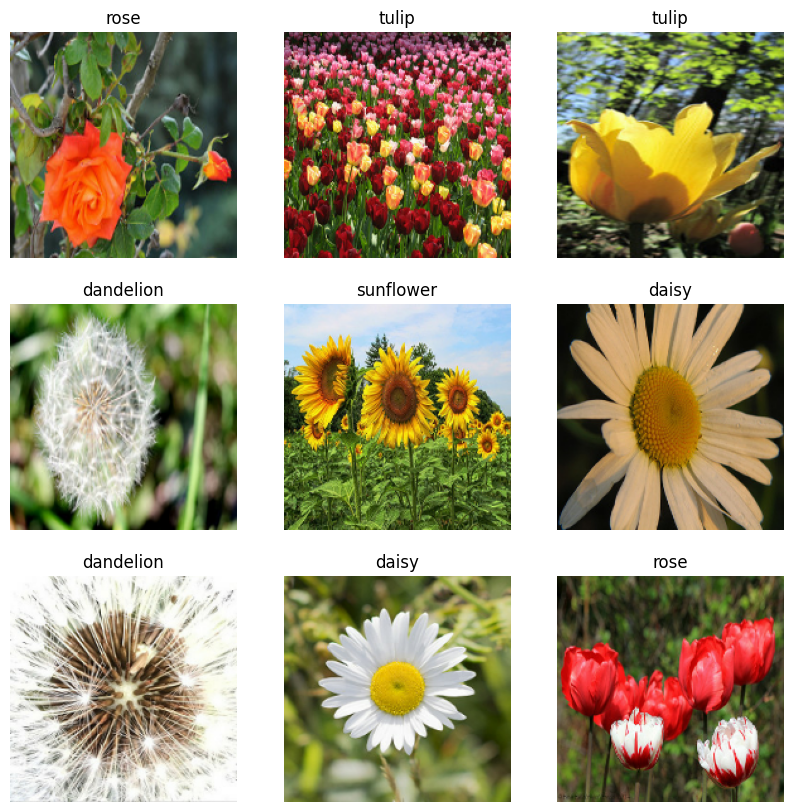

In [ ]:
i = 0
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(flower_name[labels[i]])
    plt.axis('off')


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [ ]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


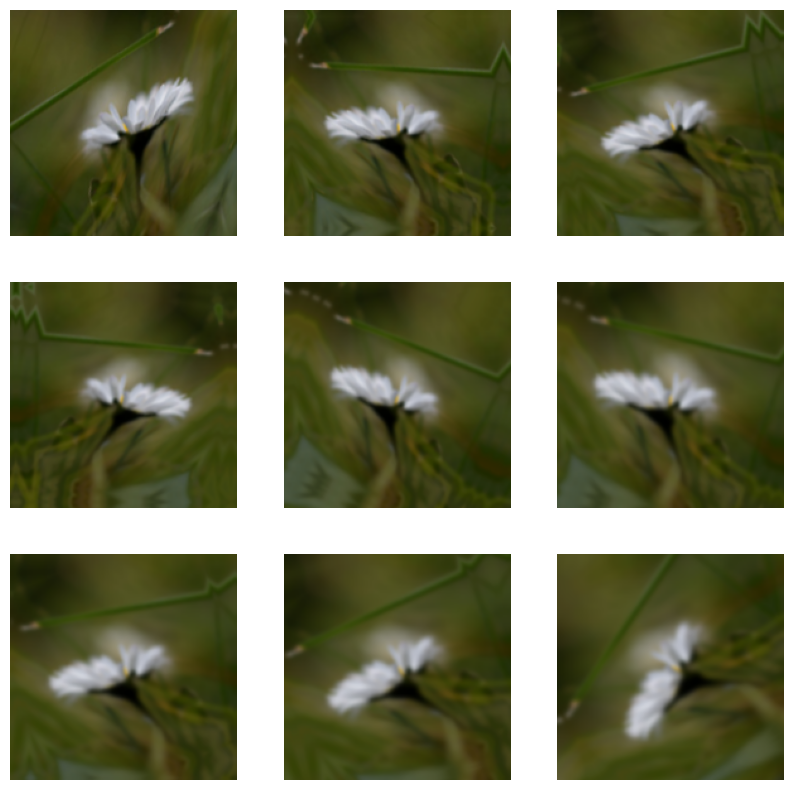

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(32,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64,3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(5)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.3418 - loss: 1.6084 - val_accuracy: 0.4820 - val_loss: 1.1618
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5449 - loss: 1.1215 - val_accuracy: 0.6072 - val_loss: 1.0349
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6047 - loss: 1.0275 - val_accuracy: 0.6280 - val_loss: 0.9573
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6375 - loss: 0.9285 - val_accuracy: 0.5910 - val_loss: 1.0113
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6631 - loss: 0.8718 - val_accuracy: 0.6744 - val_loss: 0.8357
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6891 - loss: 0.8214 - val_accuracy: 0.7092 - val_loss: 0.7666
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6840 - loss: 0.7851 - val_accuracy: 0.6744 - val_loss: 0.8893
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7250 - loss: 0.7253 - val_accu

In [ ]:
flower_name = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_name[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

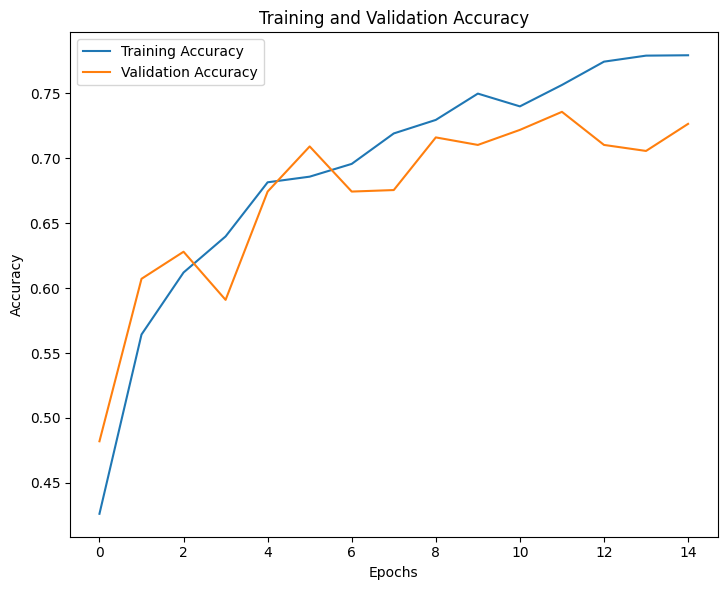

In [ ]:
import matplotlib.pyplot as plt

#training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



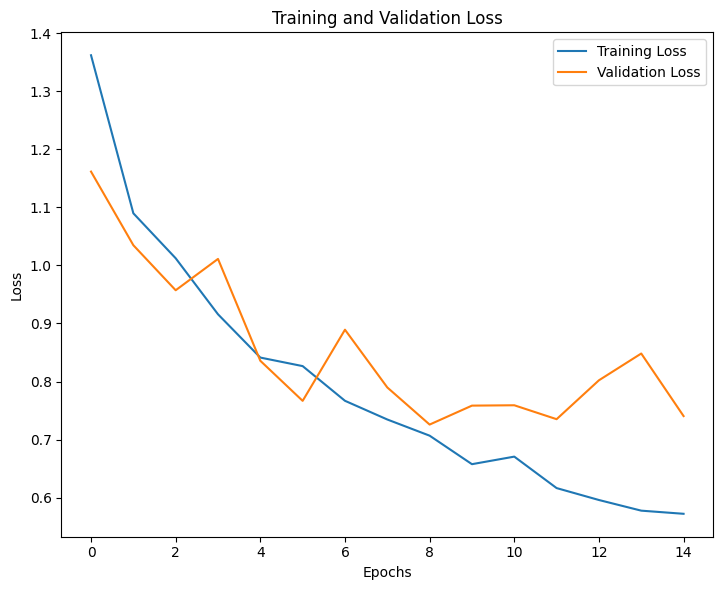

In [ ]:
#training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step


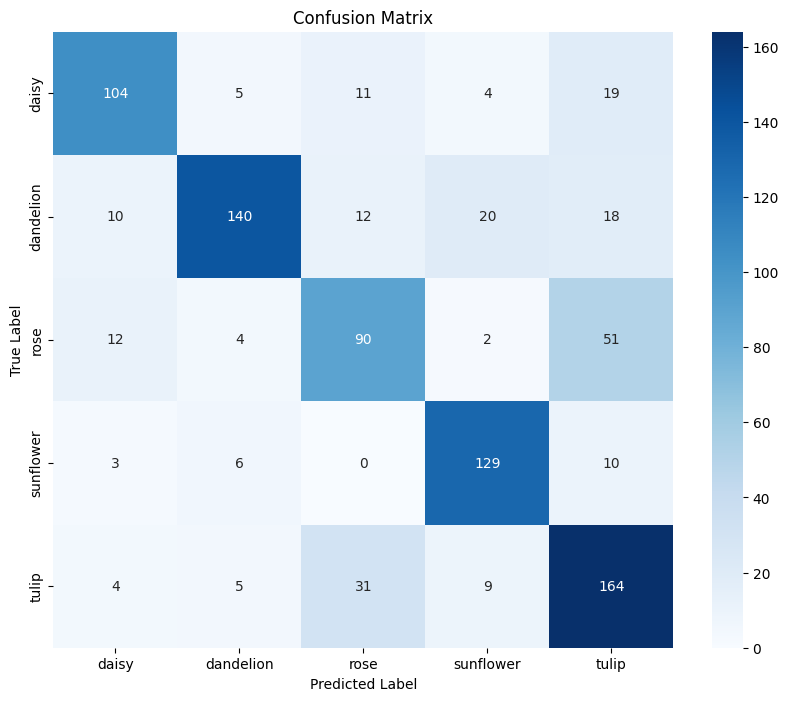

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=flower_name, yticklabels=flower_name)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=flower_name))


Classification Report:
              precision    recall  f1-score   support

       daisy       0.78      0.73      0.75       143
   dandelion       0.88      0.70      0.78       200
        rose       0.62      0.57      0.59       159
   sunflower       0.79      0.87      0.83       148
       tulip       0.63      0.77      0.69       213

    accuracy                           0.73       863
   macro avg       0.74      0.73      0.73       863
weighted avg       0.74      0.73      0.73       863



In [ ]:
import pickle

In [ ]:
model.save('Flower_Recog_Model.keras')